In [1]:
import pandas as pd
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

US_NEWS_2020_PATH = "/content/drive/MyDrive/6.S079_Project/data/us_news_2020.csv"
US_NEWS_2019_PATH = "/content/drive/MyDrive/6.S079_Project/data/us_news_2019.csv"

WEIGHTS_2019_PATH = "/content/drive/MyDrive/6.S079_Project/data/2019_weights.csv"
WEIGHTS_2020_PATH = "/content/drive/MyDrive/6.S079_Project/data/2020_weights.csv"

act_percentiles_2020 = {36: 100, 35: 99, 34: 99, 33: 97, 32: 96, 31: 94, 30: 92, 29: 90, 28: 88, 27: 85, 26: 82, 25: 78, 24: 74, 23: 70, 22: 65, 21: 60, 20: 54, 19: 48, 18: 42, 17: 36, 16: 30, 15: 24, 14: 17, 13: 11, 12: 6, 11: 2, 10: 1, 9: 1, 8: 1, 7: 1, 6: 1, 5: 1, 4: 1, 3: 1, 2: 1, 1: 1}

sat_percentiles_2020 = {1600: 100, 1590: 100, 1580: 100, 1570: 100, 1560: 100, 1550: 99, 1540: 99, 1530: 99, 1520: 99, 1510: 98, 1500: 98, 1490: 98, 1480: 97, 1470: 97, 1460: 97, 1450: 96, 1440: 96, 1430: 95, 1420: 95, 1410: 94, 1400: 94, 1390: 93, 1380: 92, 1370: 92, 1360: 91, 1350: 90, 1340: 89, 1330: 89, 1320: 88, 1310: 87, 1300: 86, 1290: 85, 1280: 84, 1270: 83, 1260: 82, 1250: 81, 1240: 80, 1230: 78, 1220: 77, 1210: 76, 1200: 74, 1190: 73, 1180: 72, 1170: 70, 1160: 69, 1150: 67, 1140: 66, 1130: 64, 1120: 62, 1110: 61, 1100: 59, 1090: 57, 1080: 55, 1070: 54, 1060: 52, 1050: 50, 1040: 48, 1030: 46, 1020: 45, 1010: 43, 1000: 41, 990: 39, 980: 38, 970: 36, 960: 34, 950: 33, 940: 31, 930: 29, 920: 28, 910: 26, 900: 25, 890: 23, 880: 22, 870: 20, 860: 19, 850: 18, 840: 16, 830: 15, 820: 14, 810: 12, 800: 11, 790: 10, 780: 9, 770: 8, 760: 7, 750: 6, 740: 5, 730: 5, 720: 4, 710: 3, 700: 3, 690: 2, 680: 2, 670: 1, 660: 1, 650: 1, 640: 1, 630: 1, 620: 1, 610: 1, 600: 1}


Mounted at /content/drive/


In [3]:
# us_news_2019 = pd.read_csv(US_NEWS_2019_PATH)
# weights_2019 = pd.read_csv(WEIGHTS_2019_PATH)


us_news_2020 = pd.read_csv(US_NEWS_2020_PATH)
weights_2020 = pd.read_csv(WEIGHTS_2020_PATH)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
clean_dict = {
    '2020 Rank': ['rank', 'int'],
    'School' : ['school', 'str'],
    'Overall Score': ['score', 'int'],
    'Peer Assessment Score': ['peer_score', 'float64'],
    'Graduation and retention rank': ['graduation_retention_rank', 'int'],
    # 'Average first year retention rate': ['freshman_retention', 'pct'],           EMBODIED BY 'Graduation and retention rank'
    'Over/Underperformance': ['graduation_diff', 'int'],
    # 'Pell Gradrate': ['pell_gradrate', 'pct'],                                    EMBODIED BY 'Social Mobility Rank'
    'Social Mobility Rank': ['social_mobility_rank', 'int'],
    'Faculty resources rank': ['faculty_resources_rank', 'int'],
    # 'Percent of classes under 20': ['small_class_pct', 'pct'],                    EMBODIED BY 'Faculty resources rank'
    # 'Percent of classes of 50 or more students': ['large_class_pct', 'pct'],      EMBODIED BY 'Faculty resources rank'
    # 'Student/faculty ratio': ['student_faculty_ratio', 'ratio'],                  EMBODIED BY 'Faculty resources rank'
    # 'Selectivity rank': ['selectivity_rank', 'int'],                              EMBODIED BY 'Faculty resources rank'
    'SAT/ACT 25th-75th percentile': ['test_scores', 'range'],
    'First year students in top 10% of high school class': ['accomplished_freshman', 'pct'],
    # 'Acceptance rate': ['acceptance_rate', 'pct'],                                NOT IN CRITERIA
    'Financial resources rank': ['financial_resources_rank', 'int'],
    'Average alumni giving rate': ['alum_giving_rate', 'pct'],
}

In [6]:
def ratio_converter(ratio_str):
  numerator, denominator = map(float, ratio_str.split(' to '))
  return numerator / denominator if denominator != 0 else None

def range_converter(range_str):
  if type(range_str) == str:
    bottom, top = map(float, range_str.split('-'))
    # converts the top and bottom range to the ACT/SAT Percentiles for the year 2020
    if top <= 36:
      bottom = act_percentiles_2020[bottom]
      top = act_percentiles_2020[top]
    else:
      bottom = sat_percentiles_2020[round(bottom, -1)]
      top = sat_percentiles_2020[round(top, -1)]
    return (bottom + top)/2
  else: # in case of 'nan' values
     return range_str

def rank_converter(df, col):
  max_rank = df[col].max()
  df[col] = (max_rank + 1 - df[col]) / max_rank
  return df

def clean_2020_data(df, trans_dic):
  for col in df.columns:
    # print(col)
    try:
      _name, _type = trans_dic[col]
      df = df.rename(columns={col: _name})
      if _type in ['int', 'float64']:
        df[_name] = pd.to_numeric(df[_name], errors='coerce')
      elif _type == 'str':
        df[_name] = df[_name].astype('str')
      elif _type == 'pct':
        df[_name] = df[_name].str.rstrip('%').astype(float) / 100
      elif _type == 'ratio':
        df[_name] = df[_name].apply(ratio_converter)
      elif _type == 'range':
        df[_name] = df[_name].apply(range_converter)
    except:
      df = df.drop(columns=col)

  #==========================================
  # CONTEXT DEPENDENT (i.e 2020) TRANSFORMATIONS
  #==========================================
  # 'NaN' represents a difference of 0
  df['graduation_diff'] = df['graduation_diff'].fillna(0)

  # adjust and normalize ranks
  # df['social_mobility_rank'] = df['social_mobility_rank'].apply(lambda v: (max(df.social_mobility_rank) + 1 - v)/max(df.social_mobility_rank))
  # df['faculty_resources_rank'] = df['faculty_resources_rank'].apply(lambda v: (max(df.faculty_resources_rank) + 1 - v)/max(df.faculty_resources_rank))

  df = rank_converter(df, 'social_mobility_rank')
  df = rank_converter(df, 'faculty_resources_rank')
  df = rank_converter(df, 'graduation_retention_rank')

  #==========================================

  return df

In [7]:
clean_2020_df = clean_2020_data(us_news_2020, clean_dict)
print(clean_2020_df)

     rank                                 school  score  peer_score  \
0       1              Princeton University (NJ)    100         4.9   
1       2                Harvard University (MA)     96         4.9   
2       3               Columbia University (NY)     94         4.7   
3       3  Massachusetts Institute of Technology     94         4.9   
4       3                   Yale University (CT)     94         4.8   
..    ...                                    ...    ...         ...   
287   281      Sam Houston State University (TX)     27         2.2   
288   281           Univ. of Missouri--St. Louis     27         2.4   
289   281            University of North Florida     27         2.4   
290   281              University of North Texas     27         2.6   
291   281          William Carey University (MS)     27         1.8   

     graduation_retention_rank  graduation_diff  social_mobility_rank  \
0                     0.997118              1.0              0.514436   
1

**From an older revision of Wikipedia:**




*The following are elements in the U.S. News rankings as of the 2020 edition.*



*   *Peer assessment: a survey of the institution's reputation among presidents, provosts, and admissions deans of other institutions (20%)*
*   *Retention: six-year graduation rate and first-year student retention rate (22%)*
*   *Social mobility: six-year graduation rates of students receiving Pell Grants—both as a standalone measure and compared to graduation rates of all other students at the school—adjusted significantly to give more credit to schools enrolling larger proportions of students receiving Pell Grants. (5%)*
*   *Faculty resources: class sizes, faculty salary, faculty degree level, student-faculty ratio, and proportion of full-time faculty (20%)*
*   *Student excellence: standardized test scores of admitted students and proportion of admitted students in upper percentiles of their high school class.* (unstated; by remainder --> 10%)
*   *Financial resources: per-student spending related to academics, student support and public service. (10%)*
*   *Graduation rate performance: comparison between modeled expected and actual graduation rate (8%)*
*   *Alumni giving rate (5%)*






## Exploring how noise affects rankings - how does schools reporting accuracy affect rankings

**columns to explore:**
*   retention 22%
*   faculty resources 20%
*   financial resources 10%
*   alumni giving rate 5%

**methods:**
1.   applying noise to data, spearman rank
2.   applying noise to weights, spearman rank
3.   applying noise to weights, fit movement distribution



In [53]:
def normalize_df(df, exclude_columns=[]):
    """
    Normalize all columns in the DataFrame to be between 0 and 1,
    except for the columns specified in exclude_columns.

    Parameters:
    df (pd.DataFrame): The input DataFrame to normalize.
    exclude_columns (list): List of columns to exclude from normalization.

    Returns:
    pd.DataFrame: A new DataFrame with normalized values.
    """
    normalized_df = df.copy()
    for column in normalized_df.columns:
        if column not in exclude_columns:
            min_val = normalized_df[column].min()
            max_val = normalized_df[column].max()
            normalized_df[column] = (normalized_df[column] - min_val) / (max_val - min_val)
    return normalized_df

# Example usage
exclude_columns = ['school', 'rank']  # Columns to exclude from normalization
ground_truth_top_20 = normalize_df(clean_2020_df[:50], exclude_columns)

original_weights = {
    'peer_score': 0.2,
    'graduation_retention_rank': 0.22,
    'social_mobility_rank': 0.05,
    'faculty_resources_rank': 0.2,
    'graduation_diff': 0.08,
    'test_scores': 0.075,                # this and one below account for 'Student Excellence (10%)'
    'accomplished_freshman': 0.025,
    'financial_resources_rank': 0.1,
    'alum_giving_rate': 0.05,
}


In [54]:
# calc. column_ranges to be used when applying noise
numeric_ground_truth_top_20 = ground_truth_top_20.drop(columns=['school', 'rank', 'score'])
column_ranges = numeric_ground_truth_top_20.max() - numeric_ground_truth_top_20.min()  # taken from the full dataset
# print(column_ranges)


## Finding Variance of Positions Moved When Noise Applied

### Noise Applied to Data

In [55]:
import pandas as pd

def calculate_rank_difference(df, df_true):
    # Ensure rank columns are not already present to avoid issues
    df = df.copy()
    df_true = df_true.copy()

    if 'Rank_df' in df.columns:
        df = df.drop(columns=['Rank_df'])
    if 'Rank_df_true' in df_true.columns:
        df_true = df_true.drop(columns=['Rank_df_true'])

    # Create a ranking column based on the row index
    df['Rank_df'] = df.index + 1
    df_true['Rank_df_true'] = df_true.index + 1

    # # Display for debugging
    # print("df with Rank_df column:")
    # display(df)
    # print("df_true with Rank_df_true column:")
    # display(df_true)

    # Merge the two dataframes on the school column
    merged_df = df.merge(df_true, on='school', suffixes=('_df', '_df_true'))

    # # Display for debugging
    # print("Merged DataFrame:")
    # display(merged_df)

    # Calculate the rank difference
    merged_df['rank_difference'] = merged_df['Rank_df_true'] - merged_df['Rank_df']

    # Return the resulting dataframe with school and rank difference
    result_df = merged_df[['school', 'rank_difference']]
    return result_df

# Example usage:
# ground_truth_top_20 = pd.DataFrame({
#     'school': ['School A', 'School B', 'School C', 'School D'],
#     'rank': [1, 2, 3, 4]
# })

# Simulate the noisy DataFrame by sorting ground_truth_top_20 in descending order
# noisy_df = ground_truth_top_20.sort_values(by='rank', ascending=False).reset_index(drop=True)

# result = calculate_rank_difference(noisy_df, ground_truth_top_20)
# print("Result DataFrame with rank differences:")
# print(result)


In [56]:
def apply_noise_to_column(df, column_name, noise_scale_factor):
    """copy the df and apply noise to the specified column"""
    # Standard deviation of the noise is a fraction of the column's range
    column_range = column_ranges[column_name]
    std_dev = column_range * noise_scale_factor

    # Applying the noise
    noisy_df = df.copy()
    noise = np.random.normal(0, std_dev, size=df[column_name].shape)
    noisy_df[column_name] += noise

    return noisy_df

def score_dataset(df, weights):
    # display(df[['school', 'rank']])
    df['new_score'] = df.apply(lambda row: sum(row[col] * weight for col, weight in weights.items()), axis=1)
    # display(df[['school', 'rank']])
    return df

In [57]:
SUBJ_COLUMNS = ['faculty_resources_rank', 'financial_resources_rank', 'alum_giving_rate']
def calc_movement_with_noisy_data(df, column_name, noise_scale_factor, num_iters=10):
    running_diff_df = pd.DataFrame(df['school'])
    running_diff_df['running_diff'] = 0

    for _ in range(num_iters):
        # Apply noise to the column
        noisy_df = apply_noise_to_column(df, column_name, noise_scale_factor)
        # noisy_df = apply_noise_to_column(df, SUBJ_COLUMNS[0], noise_scale_factor)
        # noisy_df = apply_noise_to_column(df, SUBJ_COLUMNS[1], noise_scale_factor)
        # noisy_df = apply_noise_to_column(df, SUBJ_COLUMNS[2], noise_scale_factor)

        # Score the noisy data and sort by this score descending
        noisy_df = score_dataset(noisy_df, original_weights).sort_values(by='new_score', ascending=False).reset_index(drop=True)

        # Score the ground truth data and sort by this score descending
        ground = score_dataset(ground_truth_top_20, original_weights).sort_values(by='new_score', ascending=False).reset_index(drop=True)

        # Calculate how many spots each school moved
        rank_diff_df = calculate_rank_difference(noisy_df, ground)

        # Add the rank differences to the running_diff_df
        running_diff_df = running_diff_df.merge(rank_diff_df, on='school', how='left')
        running_diff_df['rank_difference'] = running_diff_df['rank_difference'].fillna(0)
        running_diff_df['running_diff'] += running_diff_df['rank_difference']

        # Drop the 'rank_difference' column for the next iteration
        running_diff_df = running_diff_df.drop(columns=['rank_difference'])

    running_diff_df['running_diff'] /= num_iters
    # print(running_diff_df)
    return running_diff_df


In [58]:
from scipy.stats import norm
import matplotlib.pyplot as plt

def calculate_distribution(running_diff_df, plot=False):
    # Fit a normal distribution to the running_diff data
    running_diff = running_diff_df['running_diff']
    mu, std = norm.fit(running_diff)

    print(f"Mean of movements: {mu}")
    print(f"Standard deviation of movements: {std}")

    if plot:
        # Plot the histogram of the data
        plt.hist(running_diff, bins=30, density=True, alpha=0.6, color='g')

        # Plot the PDF of the fitted normal distribution
        xmin, xmax = plt.xlim()
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, mu, std)
        plt.plot(x, p, 'k', linewidth=2)
        title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
        plt.title(title)

        plt.show()

    return mu, std


Mean of movements: 1.1657341758564143e-17
Standard deviation of movements: 1.0256705123966467


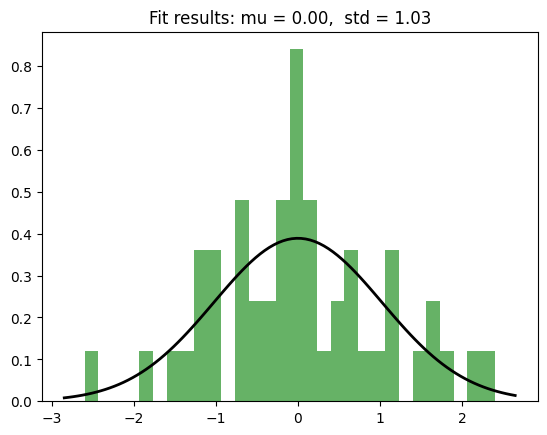

In [59]:
result_moves_df = calc_movement_with_noisy_data(ground_truth_top_20, 'faculty_resources_rank', 0.10, 10)
mean, std_dev = calculate_distribution(result_moves_df, True)

### Noise Applied to Weights

In [60]:
exclude_columns = ['school', 'rank']  # Columns to exclude from normalization
ground_truth_top_20 = normalize_df(clean_2020_df, exclude_columns)

original_weights = {
    'peer_score': 0.2,
    'graduation_retention_rank': 0.22,
    'social_mobility_rank': 0.05,
    'faculty_resources_rank': 0.2,
    'graduation_diff': 0.08,
    'test_scores': 0.075,                # this and one below account for 'Student Excellence (10%)'
    'accomplished_freshman': 0.025,
    'financial_resources_rank': 0.1,
    'alum_giving_rate': 0.05,
}

In [61]:
def make_noisy_weights(og_weights, noise_scale_factor=0.1):
    noisy_weights = {}
    for key, weight in og_weights.items():
        new_weight = np.random.normal(weight, noise_scale_factor * weight)
        noisy_weights[key] = new_weight
    total_weight = sum(noisy_weights.values())
    for col in noisy_weights:
        noisy_weights[col] /= total_weight
    return noisy_weights

# noisyW = make_noisy_weights(original_weights, 0.1)
# print(original_weights)
# print(noisyW)

# print(sum(original_weights.values()))
# print(sum(noisyW.values()))

In [62]:
import pandas as pd

def calculate_rank_difference(df, df_true):
    # Ensure rank columns are not already present to avoid issues
    df = df.copy()
    df_true = df_true.copy()

    if 'Rank_df' in df.columns:
        df = df.drop(columns=['Rank_df'])
    if 'Rank_df_true' in df_true.columns:
        df_true = df_true.drop(columns=['Rank_df_true'])

    # Create a ranking column based on the row index
    df['Rank_df'] = df.index + 1
    df_true['Rank_df_true'] = df_true.index + 1

    # # Display for debugging
    # print("df with Rank_df column:")
    # display(df)
    # print("df_true with Rank_df_true column:")
    # display(df_true)

    # Merge the two dataframes on the school column
    merged_df = df.merge(df_true, on='school', suffixes=('_df', '_df_true'))

    # # Display for debugging
    # print("Merged DataFrame:")
    # display(merged_df)

    # Calculate the rank difference
    merged_df['rank_difference'] = merged_df['Rank_df_true'] - merged_df['Rank_df']

    # Return the resulting dataframe with school and rank difference
    result_df = merged_df[['school', 'rank_difference']]
    return result_df

# Example usage:
# ground_truth_top_20 = pd.DataFrame({
#     'school': ['School A', 'School B', 'School C', 'School D'],
#     'rank': [1, 2, 3, 4]
# })

# Simulate the noisy DataFrame by sorting ground_truth_top_20 in descending order
# noisy_df = ground_truth_top_20.sort_values(by='rank', ascending=False).reset_index(drop=True)

# result = calculate_rank_difference(noisy_df, ground_truth_top_20)
# print("Result DataFrame with rank differences:")
# print(result)


In [63]:
def calc_movement_with_noisy_weights(df, noise_scale_factor, num_iters=10):
    running_diff_df = pd.DataFrame(df['school'])
    running_diff_df['running_diff'] = 0

    for _ in range(num_iters):

        new_weights = make_noisy_weights(original_weights, noise_scale_factor)

        # score the data w/ noisy weights and sort by this score descending
        noisy_df = score_dataset(df, new_weights).sort_values(by='new_score', ascending=False).reset_index(drop=True)

        # Score the ground truth data and sort by this score descending
        ground = score_dataset(ground_truth_top_20, original_weights).sort_values(by='new_score', ascending=False).reset_index(drop=True)

        # Calculate how many spots each school moved
        rank_diff_df = calculate_rank_difference(noisy_df, ground)

        # Add the rank differences to the running_diff_df
        running_diff_df = running_diff_df.merge(rank_diff_df, on='school', how='left')
        running_diff_df['rank_difference'] = running_diff_df['rank_difference'].fillna(0)
        running_diff_df['running_diff'] += running_diff_df['rank_difference']

        # Drop the 'rank_difference' column for the next iteration
        running_diff_df = running_diff_df.drop(columns=['rank_difference'])

    running_diff_df['running_diff'] /= num_iters
    # print(running_diff_df)
    return running_diff_df


In [64]:
# from scipy.stats import norm
# import matplotlib.pyplot as plt

# def calculate_distribution(running_diff_df, plot=False):
#     # Fit a normal distribution to the running_diff data
#     running_diff = running_diff_df['running_diff']
#     mu, std = norm.fit(running_diff)

#     print(f"Mean of movements: {mu}")
#     print(f"Standard deviation of movements: {std}")

#     if plot:
#         # Plot the histogram of the data
#         plt.hist(running_diff, bins=30, density=True, alpha=0.6, color='g')

#         # Plot the PDF of the fitted normal distribution
#         xmin, xmax = plt.xlim()
#         x = np.linspace(xmin, xmax, 100)
#         p = norm.pdf(x, mu, std)
#         plt.plot(x, p, 'k', linewidth=2)
#         title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
#         plt.title(title)

#         plt.show()

#     return mu, std


Mean of movements: 0.0
Standard deviation of movements: 1.5144735511016034


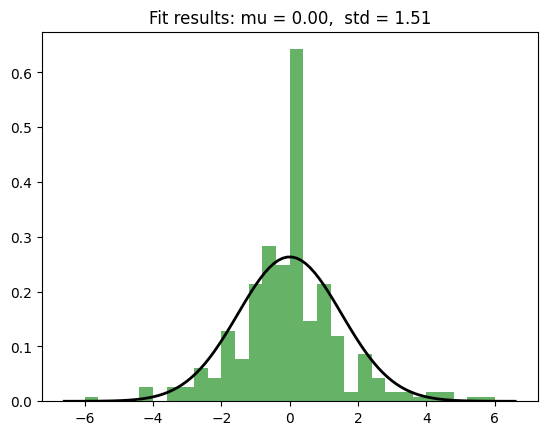

In [65]:
result_moves_df1 = calc_movement_with_noisy_weights(ground_truth_top_20, 0.10, 10)
mean, std_dev = calculate_distribution(result_moves_df1, True)

# result_moves_df2 = calc_movement_with_noisy_weights(ground_truth_top_20, 0.20, 1000)
# mean, std_dev = calculate_distribution(result_moves_df2, True)